# Numerical Gradient
---
This notebook analyses the pixelwise gradient

In [1]:
import numpy as np
import pynoisy
import xarray as xr

import matplotlib.pyplot as plt
from pynoisy.inverse import ForwardOperator,ObjectiveFunction
from tqdm.notebook import tqdm

n_jobs = 4

In [17]:
def compute_gradient_ij(i, j, solver, forward, adjoint, dx=1e-8):
    spatial_angle = solver.diffusion.spatial_angle.copy()
    source = solver.get_laplacian(forward)
    solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
    source_ij = solver.get_laplacian(forward) - source
    solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
    source_ij = source_ij / dx
    gradient = adjoint * source_ij
    return gradient

def compute_gradient1(idx, jdx, solver, forward, adjoint, dx=1e-8):
    spatial_angle = solver.diffusion.spatial_angle.copy()
    source = solver.get_laplacian(forward)
    gradient = np.zeros(shape=spatial_angle.shape)
    for i in range(gradient.shape[0]):
        for j in range(gradient.shape[1]):
            if ((idx == i) and (jdx == j)): 
                solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
                source_ij = solver.get_laplacian(forward) - source
                solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
                source_ij = source_ij / dx
                gradient[i,j] = (adjoint * source_ij).sum()
    return xr.DataArray(data=gradient, coords=solver.params.coords, attrs={'grad_type': 'loop'})

def compute_gradient(solver, forward, adjoint, dx=1e-8):
    spatial_angle = solver.diffusion.spatial_angle.copy()
    source = solver.get_laplacian(forward)
    gradient = np.zeros(shape=spatial_angle.shape)
    for i in tqdm(range(gradient.shape[0]), desc='i loop'):
        for j in tqdm(range(gradient.shape[1]), desc='j loop', leave=False):
            solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
            source_ij = solver.get_laplacian(forward) - source
            solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
            source_ij = source_ij / dx
            gradient[i,j] = (adjoint * source_ij).sum()
    return xr.DataArray(data=gradient, coords=solver.params.coords, attrs={'grad_type': 'loop'})

## Generate measurements

In [3]:
advection_true = pynoisy.advection.general_xy(64, 64)
diffusion_true = pynoisy.diffusion.general_xy(64, 64)
solver = pynoisy.forward.HGRFSolver(64, 64, advection_true, diffusion_true, seed=123)
measurements = solver.run(num_frames=64, n_jobs=n_jobs)
measurements.to_netcdf('meas.nc')
solver.save('solver.nc')

## L2 Non-krylov

### Generate gradient

In [4]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
forward_fn = lambda: solver.run(num_frames=measurements.sizes['t'], n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
forward_op = ForwardOperator(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
)

state = np.zeros(shape=solver.diffusion.spatial_angle.size)
synthetic_movie = forward_op(state.ravel())
error = synthetic_movie - measurements
loss = (error ** 2).mean()
adjoint = forward_op.adjoint(error)
gradient = compute_gradient(solver, synthetic_movie, adjoint)

synthetic_movie.to_netcdf('syn.nc')
error.to_netcdf('error.nc')
adjoint.to_netcdf('adjoint.nc')
gradient.to_netcdf('gradient.nc')

### Plots

In [ ]:
%matplotlib notebook
measurements.noisy_methods.get_animation(vmin=-1, vmax=1)

In [ ]:
%matplotlib notebook
synthetic_movie.noisy_methods.get_animation(vmin=-1, vmax=1)

In [ ]:
%matplotlib notebook
pynoisy.utils.compare_movie_frames(measurements, synthetic_movie)

### Single pixel

In [4]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = xr.load_dataarray('syn.nc')
error = xr.load_dataarray('error.nc')
adjoint = xr.load_dataarray('adjoint.nc')

gradient_new = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)

<IPython.core.display.Javascript object>


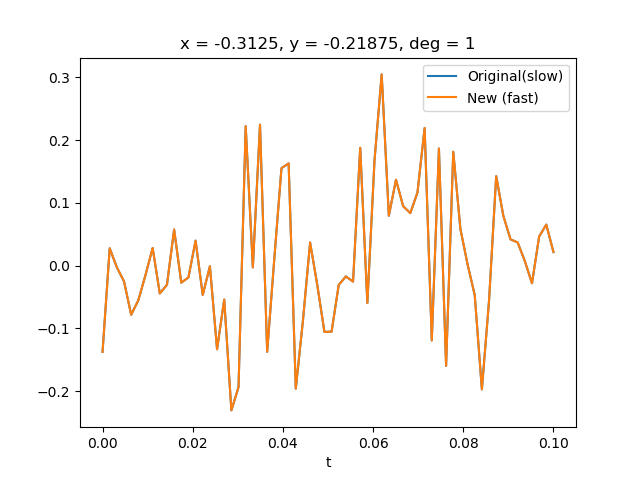

In [20]:
i = np.random.randint(0,65)
j = np.random.randint(0,65)
gradient = compute_gradient_ij(i, j, solver, synthetic_movie, adjoint, dx=1e-8)

%matplotlib notebook
gradient.sum(['x','y']).plot(label='Original(slow)')
gradient_new.isel(x=j, y=i).plot(label='New (fast)') 
plt.legend()

In [23]:
gradient = compute_gradient1(i, j, solver, synthetic_movie, adjoint, dx=1e-8)
print(gradient.isel(x=i, y=j).data, gradient_new.isel(x=i, y=j).data)

0.7235869112635991 [ 0.13671693 -0.03960443 -0.05094046 -0.01324446 -0.02842887  0.04259934
 -0.04350785  0.002558   -0.00535609 -0.28568196 -0.25690459  0.00763617
  0.0307013   0.32653703 -0.308949    0.01033099 -0.47610797 -0.44337697
 -0.515648   -0.19880171 -0.0376707   0.4941529  -0.05651242 -0.27418618
 -0.27185767  0.03754332  0.30057009  0.40587766 -0.17072907 -0.19420202
  0.00100389  0.43099695 -0.27370076 -0.34555168 -0.43273784  0.03742603
 -0.27155059 -0.1911177  -0.27037729 -0.01939255 -0.47103962 -0.19885615
  0.13903282  0.09594385  0.71391261 -0.23404355 -0.47667854 -0.3905892
 -0.46771812 -0.11999331  0.35643403 -0.03060316 -0.1558652   0.19040003
 -0.0770615   0.12637047  0.16864032 -0.09500442 -0.11290056  0.0569378
  0.20045563 -0.13137027 -0.03940771 -0.03268328]


<xarray.DataArray (x: 64, y: 64)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 -0.5 -0.4844 -0.4688 -0.4531 ... 0.4531 0.4688 0.4844
  * y        (y) float64 -0.5 -0.4844 -0.4688 -0.4531 ... 0.4531 0.4688 0.4844
    r        (x, y) float64 0.7071 0.6961 0.6854 0.6748 ... 0.6633 0.6741 0.685
    theta    (x, y) float64 -2.356 -2.372 -2.388 -2.405 ... 0.7521 0.769 0.7854
Attributes:
    grad_type:  loop

### Load and analyse

In [12]:

solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
forward_fn = lambda: solver.run(num_frames=measurements.sizes['t'], n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
forward_op = ForwardOperator(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
)

i = np.random.randint(0,65)
j = np.random.randint(0,65)
gradient = compute_gradient_ij(i, j, solver, synthetic_movie, adjoint)
 
#synthetic_movie.to_netcdf('syn.nc')
#error.to_netcdf('error.nc')
#adjoint.to_netcdf('adjoint.nc')
#gradient.to_netcdf('gradient1.nc')

In [22]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
gradient =  xr.load_dataarray('gradient.nc')
adjoint =  xr.load_dataarray('adjoint.nc')

i = np.random.randint(0,65)
j = np.random.randint(0,65)
gradient1 = compute_gradient1(i, j, solver, synthetic_movie, adjoint)

print(gradient1.isel(x=i, y=j).data, gradient.isel(x=i, y=j).data)


0.35375905249668366 0.04523400423409116


<IPython.core.display.Javascript object>


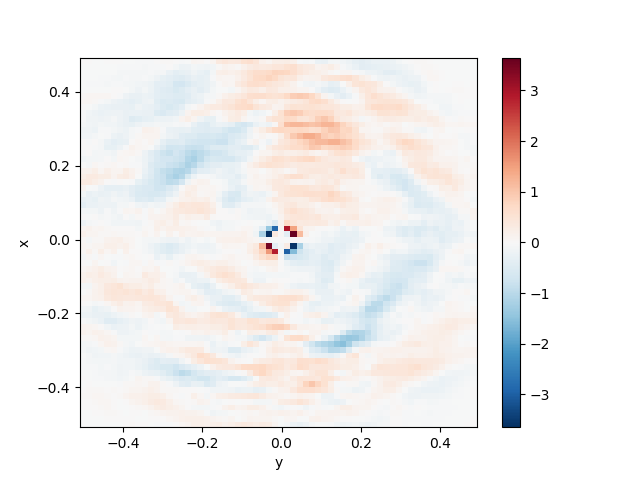

In [8]:
%matplotlib notebook
gradient.plot()

<IPython.core.display.Javascript object>


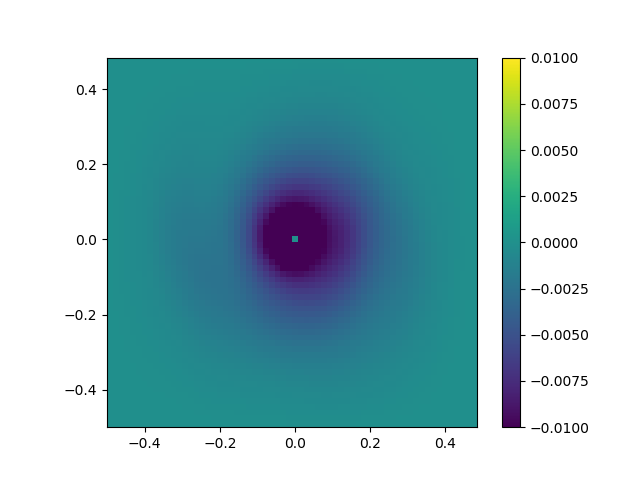

In [21]:
%matplotlib notebook
adjoint.noisy_methods.get_animation(vmin=-0.01, vmax=0.01)

In [15]:
gradient_new = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)

<IPython.core.display.Javascript object>


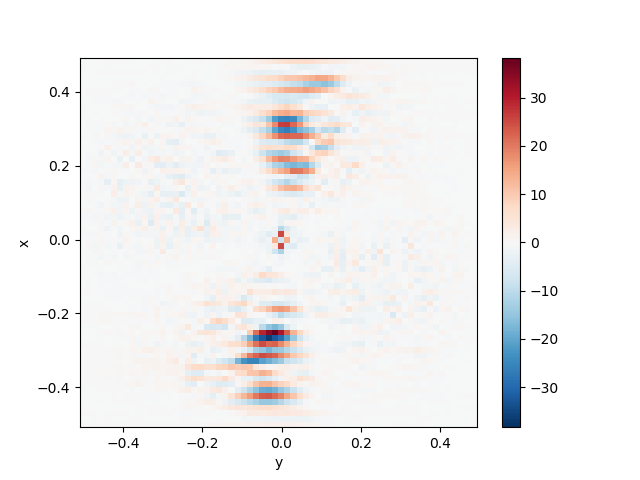

In [16]:
%matplotlib notebook
gradient_new.plot()

## Krylov

### Generate gradient

In [ ]:
degree = 8

adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
forward_fn = lambda: solver.run(num_frames=measurements.sizes['t'], n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
k_matrix_fn = lambda source, degree: solver.run(source=source, nrecur=degree, n_jobs=n_jobs).data.reshape(degree, -1)
forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=degree,
    k_matrix_fn=k_matrix_fn
)

state = np.zeros(shape=solver.diffusion.spatial_angle.size)
synthetic_movie = forward_op(state.ravel())
error = synthetic_movie - measurements
loss = (error ** 2).mean()
adjoint = forward_op.adjoint(error)
gradient = compute_gradient(solver, synthetic_movie, adjoint)
b
synthetic_movie.to_netcdf('syn_krylov.nc')
error.to_netcdf('error_krylov.nc')
adjoint.to_netcdf('adjoint_krylov.nc')
gradient.to_netcdf('gradient_krylov.nc')

### Load and analyse

In [ ]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = xr.load_dataarray('syn_krylov.nc')
error = xr.load_dataarray('error_krylov.nc')
adjoint = xr.load_dataarray('adjoint_krylov.nc')
gradient = xr.load_dataarray('gradient_krylov.nc')

adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
forward_fn = lambda: solver.run(num_frames=measurements.sizes['t'], n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
forward_op = ForwardOperator(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
)

In [ ]:
loss

In [ ]:
solver.params['num_unknowns'] = int(solver.diffusion.spatial_angle.size)

In [ ]:
np.zeros(shape=solver.params.num_unknowns)

In [ ]:
%matplotlib notebook
(adjoint * solver.diffusion.correlation_length**2)

In [ ]:
%matplotlib notebook
gradient.clip(min=-1e-6, max=1e-6).plot()

In [ ]:
gradient1 = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)

In [ ]:
%matplotlib notebook
gradient1.clip(min=-0.01, max=0.01).plot()

## DEBUG

In [ ]:
%matplotlib notebook
grad1.sum(['x','y']).plot(label='grad1')
grad2.sum(['x','y']).plot(label='grad2')
plt.legend()

In [ ]:
def compute_h(i, j):
    theta = solver.diffusion.spatial_angle[i, j].data
    vx = solver.advection.vx[i, j].data
    vy = solver.advection.vx[i, j].data
    u0 = [1.0, vy, vx]
    u1 = [0.0, np.cos(theta), np.sin(theta)]
    u2 = [0.0, -np.sin(theta), np.cos(theta)]
    lam0 = solver.diffusion.correlation_time[i, j].data
    lam1 = solver.diffusion.correlation_length[i, j].data
    lam2 = solver.diffusion.tensor_ratio.data * lam1
    h = np.empty((3,3))
    for i in range(3):
        for j in range(3):
            h[i,j] = lam0 * lam0 * u0[i] * u0[j] + \
                        lam1 * lam1 * u1[i] * u1[j] + \
                            lam2 * lam2 * u2[i] * u2[j]
    return h

def compute_dh(i, j, dx0, dx1, dx2):
    dx = [dx0, dx1, dx2]
    hp, hm, dh = np.empty((3,3,3)), np.empty((3,3,3)), np.empty((3,3,3))
    hp[0] = compute_h(i,j)
    hm[0] = compute_h(i,j)
    hp[1] = compute_h(i,j+1)
    hm[1] = compute_h(i,j-1)
    hp[2] = compute_h(i+1,j)
    hm[2] = compute_h(i-1,j)
    for ii in range(3):
        for jj in range(3):
            for kk in range(3):
                 dh[ii][jj][kk] = 0.5 * ( hp[kk][ii][jj] - hm[kk][ii][jj] ) / dx[kk]
    return dh    
    
def compute_coeff(i, j):
    dx2 = 20.0 / 64.0
    dx1 = dx2
    dx0 = 100.0 / 64.0
    h = compute_h(i,j)
    dh = compute_dh(i, j, dx0, dx1, dx2)
    coeff = np.empty((10,1))
    coeff[0] = -h[2][2] / (dx2 * dx2);
    coeff[1] = -0.5 * h[1][2] / (dx1 * dx2);
    coeff[2] = -h[1][1] / (dx1 * dx1);
    coeff[3] = -0.5 * h[0][2] / (dx0 * dx2);
    coeff[4] = -0.5 * h[0][1] / (dx0 * dx1);
    coeff[5] = -h[0][0] / (dx0 * dx0);
    coeff[6] = -0.5 * ( dh[0][2][0] + dh[1][2][1] + dh[2][2][2] ) / dx2;
    coeff[7] = -0.5 * ( dh[0][1][0] + dh[1][1][1] + dh[2][1][2] ) / dx1;
    coeff[8] = -0.5 * ( dh[0][0][0] + dh[1][0][1] + dh[2][0][2] ) / dx0;
    coeff[9] = -2. * ( coeff[0] + coeff[2] + coeff[5] ) + 1.0;  
    return coeff

In [ ]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = measurements.copy()
adjoint = xr.ones_like(measurements)
adjoint.name='data_raw'
adjoint.to_netcdf('/tmp/adjoint.nc')

In [ ]:
dx = 0.00000000001
gridi, gridj = 39, 45
theta = solver.diffusion.spatial_angle[gridi, gridj].data
solver.diffusion.spatial_angle[gridi, gridj] = theta
coeff1 = compute_coeff(gridi, gridj+1)
solver.diffusion.spatial_angle[gridi, gridj] = theta + dx
coeff2 = compute_coeff(gridi, gridj+1)
coeff1 = (coeff2 - coeff1) / dx
solver.diffusion.spatial_angle[gridi, gridj] = theta
print(coeff1)

In [ ]:
dx = 0.00000000001
gridi, gridj = 39, 45
theta = solver.diffusion.spatial_angle[gridi, gridj].data
solver.diffusion.spatial_angle[gridi, gridj] = theta
coeff1 = compute_coeff(gridi-1, gridj)
solver.diffusion.spatial_angle[gridi, gridj] = theta + dx
coeff2 = compute_coeff(gridi-1, gridj)
coeff1 = (coeff2 - coeff1) / dx
solver.diffusion.spatial_angle[gridi, gridj] = theta
print(coeff1)

In [ ]:

theta = solver.diffusion.spatial_angle[i, j].data
u1 = [0.0, np.cos(theta), np.sin(theta)]
u2 = [0.0, -np.sin(theta), np.cos(theta)]
lam1 = solver.diffusion.correlation_length[i, j].data
lam2 = solver.diffusion.tensor_ratio.data * lam1

h = np.empty((3,3))
for i in range(3):
    for j in range(3):
        h[i,j] = lam1 * lam1 * (u2[i]*u1[j] + u1[i]*u2[j]) - lam2 * lam2 * (u1[i]*u2[j] + u2[i]*u1[j])
        
print(-h[2,2] / dx**2)

In [ ]:
solver.diffusion.spatial_angle[gridi, gridj]

In [ ]:



        
h2 = np.empty((3,3))
dx = 0.0000000001
theta = solver.diffusion.spatial_angle[i, j].data + dx
u1 = [0.0, np.cos(theta), np.sin(theta)]
u2 = [0.0, -np.sin(theta), np.cos(theta)]
for i in range(3):
    for j in range(3):
        h2[i,j] = lam1 * lam1 * u1[i] * u1[j] + lam2 * lam2 * u2[i] * u2[j]
        
h = (h2 - h1) / dx

In [ ]:
dx2 = 20.0 / 64.0
-h[2][2] / (dx2 * dx2)

In [ ]:
%matplotlib notebook
plt.imshow(grad1.isel(t=0), origin='lower')
plt.colorbar()

In [ ]:
%matplotlib notebook
solver.diffusion.correlation_length.plot()

In [ ]:
 = 4
degree = 8

solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = xr.load_dataarray('syn.nc')
error= xr.load_dataarray('error.nc')
adjoint = xr.load_dataarray('/tmp/adjoint.nc')

adjoint_fn = forward_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
gradient_fn = pynoisy.inverse.spatial_angle_gradient(solver)
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
k_matrix_fn = lambda source, degree: solver.run(source=source, nrecur=degree, n_jobs=n_jobs).data.reshape(degree, -1)
forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=degree,
    k_matrix_fn=k_matrix_fn
)
state = np.ones(shape=solver.params.num_unknowns)
set_state_fn(state)

In [ ]:
n_jobs = 4
degree = 8

solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = xr.load_dataarray('syn.nc')
error= xr.load_dataarray('error.nc')
adjoint = xr.load_dataarray('/tmp/adjoint.nc')

adjoint_fn = forward_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
gradient_fn = pynoisy.inverse.spatial_angle_gradient(solver)
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
k_matrix_fn = lambda source, degree: solver.run(source=source, nrecur=degree, n_jobs=n_jobs).data.reshape(degree, -1)
forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=degree,
    k_matrix_fn=k_matrix_fn
)
state = np.ones(shape=solver.params.num_unknowns)
set_state_fn(state)

In [ ]:
grad2 = solver.get_laplacian(synthetic_movie, solver_id=6)
grad2.mean()

In [ ]:
127224 / 19 / (64 * 64)

In [ ]:
k = 4
i = 39
j = 40
ni = nj = nk = 64
nentries = 19
nentries * (k*ni*nj + j*ni + i) 

In [ ]:
1294584 / 19 / (64*64)

In [ ]:
%matplotlib notebook
gradient1.noisy_methods.get_animation()

In [ ]:
adjoint_fn = forward_fn = lambda source: solver.run(source=source, n_jobs=4)
gradient_fn = pynoisy.inverse.spatial_angle_gradient(solver)
solver.params['mask'] = solver.params.r < 0.5 - 2.0 / solver.params.dims['x']
solver.params.attrs['num_unknowns'] = solver.params.mask.sum().data

In [ ]:
dx = 1e-2
spatial_angle = solver.diffusion.spatial_angle.copy()
source = solver.get_laplacian(measurements)
gradient = np.zeros(shape=solver.params.num_unknowns)

i, j = 40, 40
solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
source_ij = solver.get_laplacian(measurements) - source
solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
source_ij = source_ij / dx

gradient = xr.zeros_like(measurements)
gradient[:] = source_ij

In [ ]:
%matplotlib notebook
gradient.noisy_methods.get_animation()